In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm
from statsmodels.tsa.statespace.varmax import VARMAX

from typing import Union
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

from itertools import product


import torch
from torchmetrics.regression import MeanAbsoluteError
from torchmetrics import MeanAbsolutePercentageError

plt.rcParams['font.family'] = 'AppleGothic'

np.random.seed(42)

In [3]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [6]:
columns = {
    'realgdp': '실질GDP / Real GDP',
    'realcons': '실질 개인 소비 지출 / Real personal consumption expenditure',
    'realinv': '실질 국내 총 민간 투자 / Real domestic gross private investment',
    'realgovt': '실질 연방 소비 지출 및 투자 / Real Federal Consumer Spending and Investment',
    'realdpi': '실질 민간 가처분 소득 / Real private disposable income',
    'cpi': '분기 말 소비자물가지수 / Consumer Price Index at the end of the quarter',
    'm1': 'M1 명목 통화량 / M1 nominal money supply',
    'tbilrate': '3개월 만기 국채의 분기별 월평균 금리 / Quarterly average monthly interest rate on 3-month Treasury bonds',
    'unemp': '실업률 / Unemployment rate',
    'pop': '분기 말 총인구 / Total population at the end of the quarter',
    'infl': '인플레이션율 / Inflation rate',
    'realint': '실질 이자율 / Real interest rate'
}

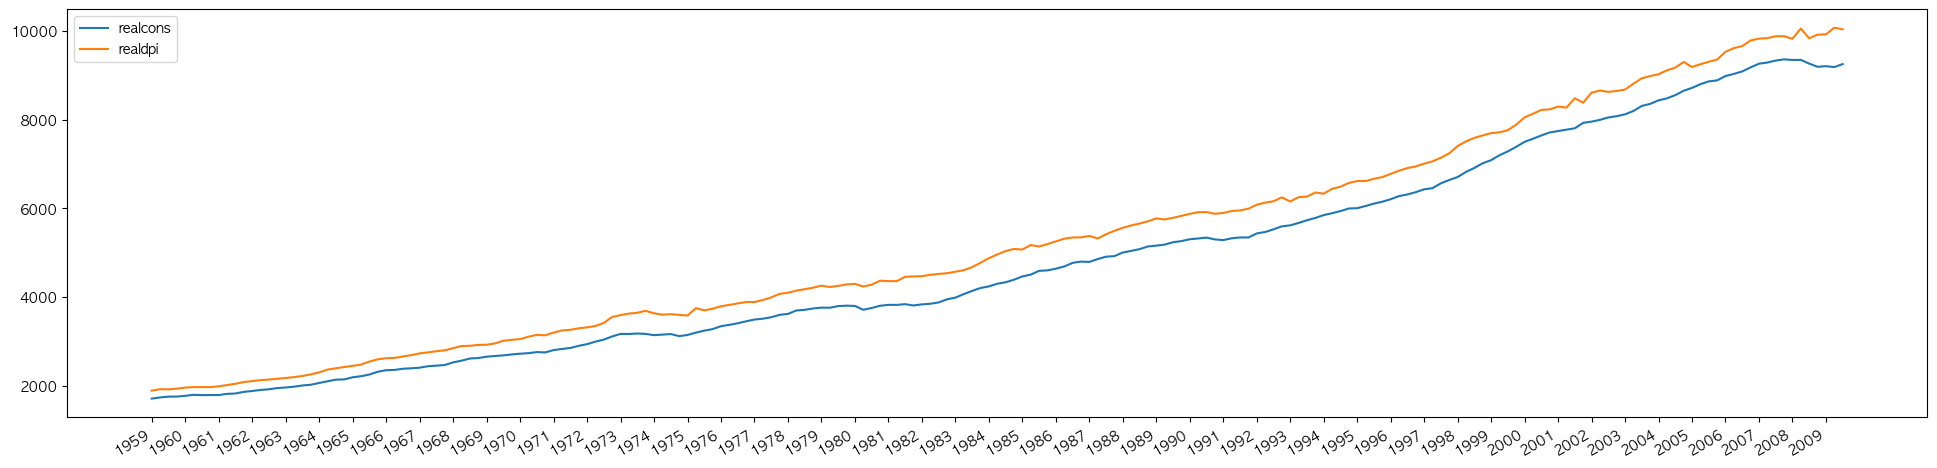

In [14]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(24,6))
macro_econ_data[['realcons', 'realdpi']].plot(ax=ax)
plt.xticks( np.arange(0, 204, 4),  np.arange(1959, 2010, 1)  )
fig.autofmt_xdate()

In [15]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])
ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])
ad_fuller_result_1, ad_fuller_result_2

((2.9860253519546864,
  1.0,
  2,
  200,
  {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
  2014.6630929800756),
 (1.5499123380509636,
  0.9976992503412904,
  4,
  198,
  {'1%': -3.4638151713286316,
   '5%': -2.876250632135043,
   '10%': -2.574611347821651},
  1793.172616888144))

In [16]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])
ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])
ad_fuller_result_1, ad_fuller_result_2

((-8.864893340673008,
  1.4493606159108096e-14,
  1,
  200,
  {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
  2009.0790249915815),
 (-4.204306080845247,
  0.0006479282158627571,
  3,
  198,
  {'1%': -3.4638151713286316,
   '5%': -2.876250632135043,
   '10%': -2.574611347821651},
  1784.2903520562793))

In [18]:
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

In [ ]:
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

granger_1, granger_2

In [ ]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0)
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1)
plt.show()

In [27]:
realgdp_residuals = best_model_fit.resid['realdpi']

tr = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))
print(tr)

      lb_stat  lb_pvalue
1    0.011643   0.914071
2    0.029401   0.985407
3    0.075832   0.994571
4    0.377928   0.984244
5    9.142482   0.103514
6    9.165317   0.164492
7    9.270064   0.233844
8   10.811491   0.212611
9   13.318034   0.148736
10  15.287286   0.121934


In [28]:
realgdp_residuals = best_model_fit.resid['realcons']

tr = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))
print(tr)

     lb_stat  lb_pvalue
1   0.023877   0.877197
2   0.068719   0.966224
3   0.068795   0.995299
4   0.235724   0.993577
5   0.377780   0.995920
6   0.787312   0.992410
7   1.015247   0.994579
8   2.150378   0.976051
9   2.437075   0.982528
10  2.442741   0.991684


In [29]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4
print(TRAIN_LEN, HORIZON, WINDOW)

162 40 4


In [36]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VAR':

        realdpi_pred_VAR = []
        realcons_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VAR.extend(oos_pred_realdpi)
            realcons_pred_VAR.extend(oos_pred_realcons)
        
        return realdpi_pred_VAR, realcons_pred_VAR
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [69]:
test = endog[163:]

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test.head()

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.222069,7354.322880,7716.0,7199.9
164,8053.4,7501.3,7897.184865,7430.251869,7716.0,7199.9
165,8135.9,7571.8,7960.558180,7496.624760,7716.0,7199.9
166,8222.3,7645.9,8014.750245,7556.608726,7716.0,7199.9
167,8234.6,7713.5,8080.695672,7630.997186,8135.9,7571.8


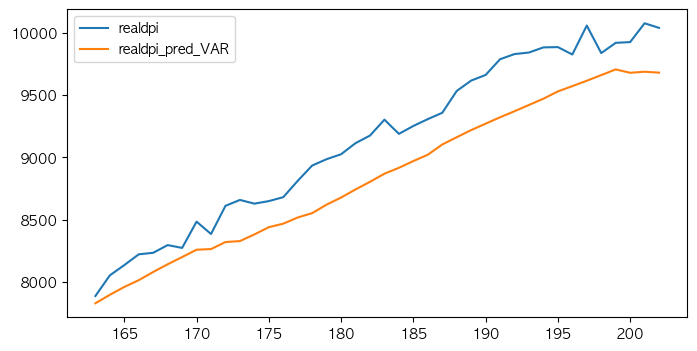

In [45]:
ax = test[['realdpi','realdpi_pred_VAR']].plot( figsize=(8,4),  layout='constrained')

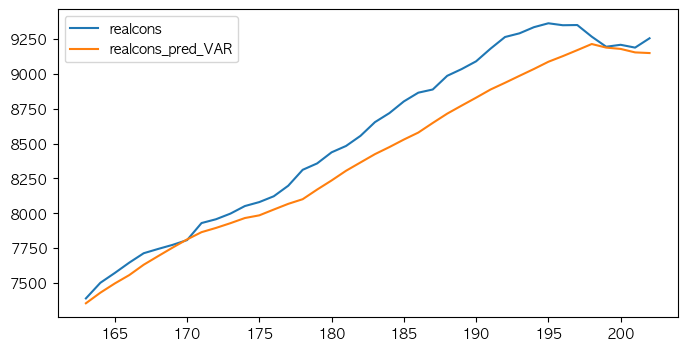

In [46]:
ax = test[['realcons','realcons_pred_VAR']].plot( figsize=(8,4),  layout='constrained')

In [50]:
mean_abs_percentage_error = MeanAbsolutePercentageError()
mapes = {}

pred_last_value = torch.FloatTensor( test['realdpi_pred_last'].values)
pred_last_value2 = torch.FloatTensor( test['realcons_pred_last'].values)
pred_VARX = torch.FloatTensor( test['realdpi_pred_VAR'].values)
pred_VARX2 = torch.FloatTensor( test['realcons_pred_VAR'].values)
actual = torch.FloatTensor(test['realdpi'].values)
actual2 = torch.FloatTensor(test['realcons'].values)


mapes['mape_naive_seasonal_dpi'] = mean_abs_percentage_error( pred_last_value, actual).item()
mapes['mape_VARX_dpi'] = mean_abs_percentage_error( pred_VARX, actual ).item()

mapes['mape_naive_seasonal_cons'] = mean_abs_percentage_error( pred_last_value2, actual2).item()
mapes['mape_VARX_cons'] = mean_abs_percentage_error( pred_VARX2, actual2 ).item()

mapes

{'mape_naive_seasonal_dpi': 0.022626180201768875,
 'mape_VARX_dpi': 0.03138555958867073,
 'mape_naive_seasonal_cons': 0.024593140929937363,
 'mape_VARX_cons': 0.017711829394102097}

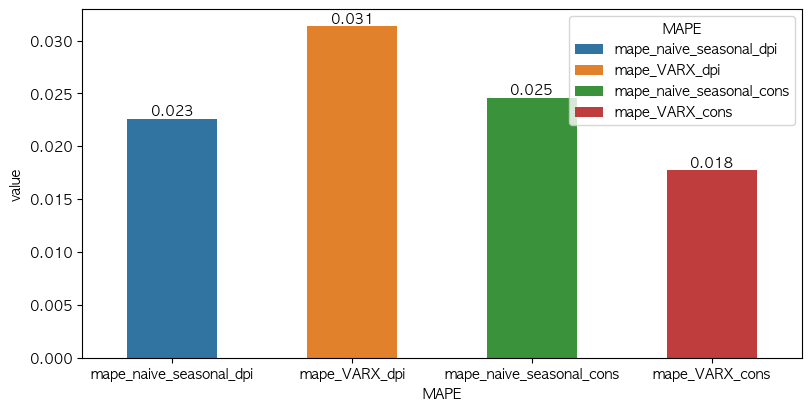

In [51]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([mapes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )

ax.set_xlabel('MAPE')
ax.legend(title='MAPE')
for index, label in enumerate(mapes):   
    ax.bar_label(ax.containers[index], fmt='%.3f',  fontsize=10)